In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(variancePartition)
library(lme4)
library(olsrr)

library(gridExtra)
library(cowplot)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: foreach
Loading required package: scales
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterAppl

In [2]:
setwd("~/ownCloud/Meng/")

In [3]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

In [4]:
load(file = "100_plus_project/Metadata/metadata_imp_20230223.Rdata")

In [5]:
metadata <- metadata_imp

In [6]:
dim(High_quality_protein_intensity_matrix)
dim(metadata)

[1] 3448  191

[1] 190  16

In [7]:
#####################Some test to find if some values are NA#######################
length(which(is.na(metadata$autopsy)))
complete_case <- which(complete.cases(metadata))
metadata[-complete_case,]
length(complete_case)

[1] 0

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
219,SVU 10-277,SVU 10/277,M,50,NA,ND,NA,1,1,33,20190326_220_SVU10_277_ND_022,1,1,A,1,5.666667
220,SVU 11-120,SVU 11/120,M,62,NA,ND,NA,1,1,33,20190416_221_SVU11_120_ND_108,1,1,A,1,5.666667


[1] 188

In [8]:
complete_case

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
 [37]  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
 [55]  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
 [73]  74  75  76  77  78  79  80  81  82  83  84  85  86  88  89  90  91  92
 [91]  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
[109] 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
[127] 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
[145] 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
[163] 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
[181] 183 184 185 186 187 188 189 190

In [9]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index+1)
}

In [10]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,A,0.6,6.166667
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,C,1.0,5.283333
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,A,1.0,7.916667
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,C,1.0,5.916667
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,C,0.6,4.583333
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,C,2.6,5.500000
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,C,1.0,5.083333
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,C,3.2,2.000000
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,O,1.0,7.250000


In [11]:
metadata$PMD <- as.numeric(metadata$pmd_numeric)
metadata$age <- as.numeric(metadata$age)
metadata$weight <- as.numeric(metadata$weight)
metadata$batch <- as.factor(cal_sample_batch_index(metadata$filenames))
metadata$GROUP <- as.factor(metadata$GROUP)
metadata$sex <- as.factor(metadata$sex)
metadata$Braak <- as.numeric(metadata$braak)
metadata$amyloid <- as.numeric(metadata$amyloid)
metadata$apoe <- as.factor(metadata$apoe)
metadata$apoe_PRS <- log2(as.numeric(metadata$apoe_OR))

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”

In [ ]:
save(metadata, file = "100_plus_project/Metadata/)

In [12]:
###################If I should do cyclic loess normzlization###############################
#final_protein_intensity_loess_log <- normalizeCyclicLoess(log2(final_protein_intensity_matrix[, -1]), 
#                                                      iterations = 10, method = "fast")

In [13]:
High_quality_protein_intensity_matrix

protein,intensity_20190325_121_S16_020_CHC_011,intensity_20190325_125_S16_044_CHC_007,intensity_20190325_127_S16_094_CHC_004,intensity_20190325_16_04_037_AD_008,intensity_20190325_183_S10_292_AD_010,intensity_20190325_194_S02_055_ND_005,intensity_20190325_31_01_184_AD_006,intensity_20190325_57_S97_235_AD_003,intensity_20190325_77_S11_072_ND_012,⋯,intensity_20190507_21_01_032_AD_221,intensity_20190507_27_00_204_AD_211,intensity_20190507_29_S99_240_AD_219,intensity_20190507_30_S05_040_AD_209,intensity_20190507_63_04_027_AD_217,intensity_20190507_72_S99_219_AD_213,intensity_20190606_106_NABCA14_08_ND_RERUN,intensity_20190606_140_2017_027_CHC_RERUN,intensity_20190606_20_S00_166_AD_RERUN,intensity_20190606_9_S93_025_AD_RERUN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC12A2,836.80987,881.06951,780.98996,701.68957,1245.36392,1264.51784,795.12072,810.26815,729.90767,⋯,917.08439,851.88556,796.88906,663.22765,941.54816,932.08231,1052.79254,917.45960,813.67832,865.75086
CASKIN1,1344.34121,1049.89367,951.79843,904.19465,651.40811,1497.91167,667.30437,865.30500,1022.58727,⋯,753.06675,692.13651,507.57334,1103.08975,693.45142,874.55879,900.35601,786.30930,1033.71160,805.19428
GNG2,563.31659,208.31086,350.94199,232.02806,210.62083,242.26756,161.09872,218.97718,377.72039,⋯,183.91086,133.00780,153.79479,229.45112,256.21317,195.04436,164.62043,179.79677,190.60729,213.85196
CARNS1,33.40392,75.57282,98.33277,23.09145,307.11463,101.08390,99.64686,112.03207,42.20178,⋯,55.58988,164.73288,49.12562,29.13836,139.90373,53.68109,93.04210,134.53807,104.82207,119.33094
FH,3326.60924,4564.59875,5238.09499,3906.98843,3662.44502,2009.79815,4318.91514,4116.81168,3991.92090,⋯,5109.84351,3684.03726,4991.14490,3601.41144,3848.70803,4560.84202,4917.91263,4758.63636,4190.09930,5038.00332
EFHD2,508.48022,571.96033,1722.07907,406.67353,543.35073,303.94769,783.93013,1165.80121,602.14280,⋯,712.87081,802.54044,890.61294,375.67400,657.88005,1211.05592,1528.88668,1777.48636,945.07368,1577.98572
PCLO,2369.33932,1029.75211,954.52388,1652.92346,1520.51650,2583.51659,1804.85497,1677.07029,2357.03278,⋯,2564.36720,1907.63409,2410.77471,2943.85799,831.38952,2446.47573,3547.34325,3332.46509,2784.91200,3311.11634
HSPA1A;HSPA1B,7124.78872,6129.39109,7834.88395,6527.18995,11445.45274,5029.23535,9876.28243,10660.13041,5758.54005,⋯,7159.83303,10712.43211,10114.79332,7628.30538,6270.58343,10350.33344,8784.79637,8276.78113,8458.72235,10499.10328
STIP1,1028.55835,767.89888,2651.63959,988.76516,1302.06611,334.72548,1739.11160,2405.02599,774.17336,⋯,1464.82937,1376.75255,1398.01876,1322.92881,1183.51846,1722.29743,2017.77206,1685.91565,1494.30325,2335.50754


In [14]:
############variance partition analysis##############

In [15]:
form <- ~ (1|sex) + age + braak + amyloid + pmd_numeric + (1|batch) + apoe_PRS + weight

In [16]:
#form <- ~ (1|sex) + age + weight + ph + pmd_numeric + braak + (1|batch)

In [17]:
varPart <- fitExtractVarPartModel(log2(High_quality_protein_intensity_matrix[,complete_case+1]), 
                                  form, metadata[complete_case,])

vp <- sortCols(varPart)

Dividing work into 100 chunks...

Total:35 s


In [18]:
p_1 <- plotVarPart(vp, col = c('#F8766D', '#CD9600', '#7CAE00', '#00BE67', '#00BFC4', '#00A9FF', '#C77CFF', '#FF61CC', "grey85"))

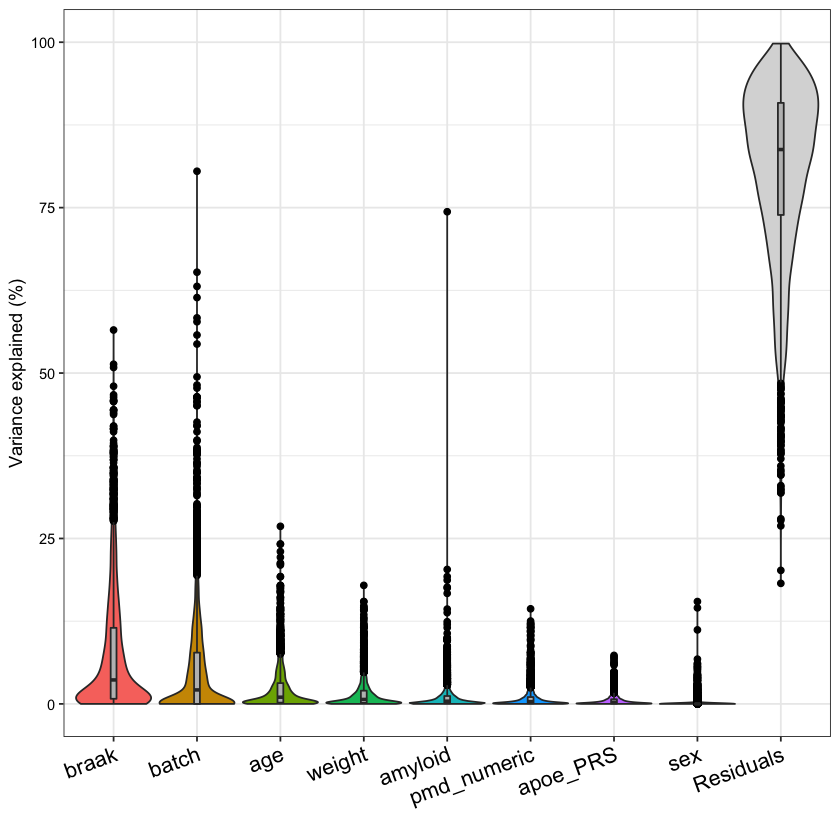

In [19]:
p_1

In [89]:
pdf("100_plus_plots/proteomics/variance_partition_before_combat-20230522.pdf", width=6, height=6)
p_1
dev.off()

pdf 
  2

In [91]:
########################start to reduce variance cause by technical reason###############################
########################start to reduce variance cause by technical reason###############################
########################start to reduce variance cause by technical reason###############################

In [20]:
protein_intensity_combat  <-  ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)

rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [21]:
form <- ~ (1|sex) + age + braak + amyloid + pmd_numeric + (1|batch) + apoe_PRS + weight
varPart <- fitExtractVarPartModel(protein_intensity_combat[,complete_case], 
                                  form, metadata[complete_case,])

vp <- sortCols(varPart)

Dividing work into 100 chunks...

Total:31 s


In [22]:
p_2 <- plotVarPart(vp, col = c('#F8766D', '#7CAE00', '#00BE67', '#00A9FF', '#00BFC4', '#C77CFF', '#CD9600', '#FF61CC', "grey85"))

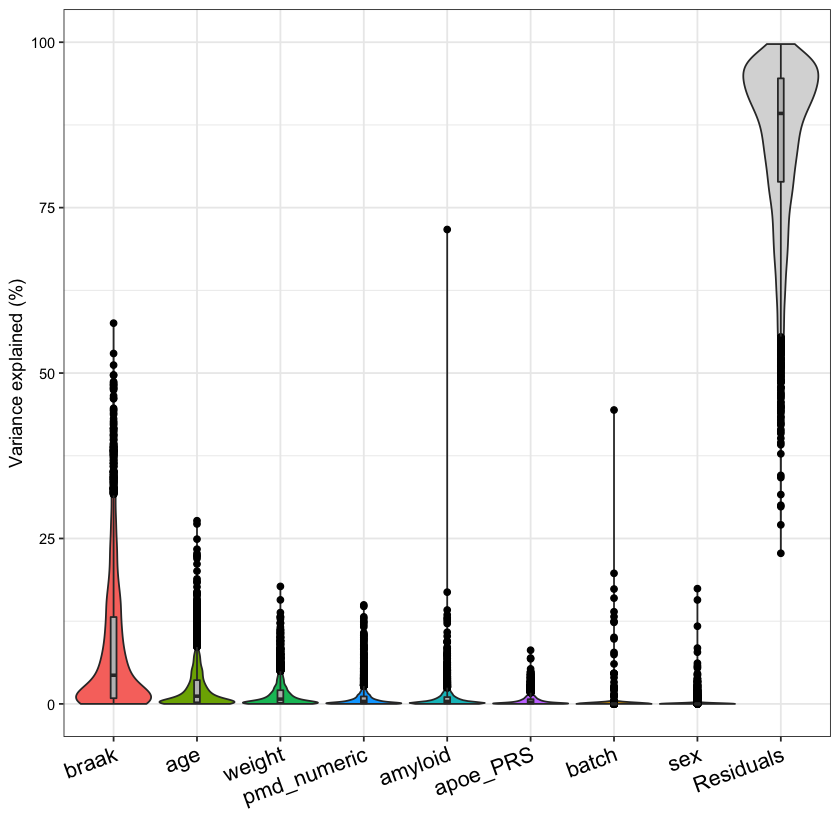

In [23]:
p_2

In [99]:
pdf("100_plus_plots/proteomics/variance_partition_after_combat-20230522.pdf", width=6, height=6)
p_2
dev.off()

pdf 
  2

In [100]:
#################################Test a single protein of Braak####################################
#i <- which.max(varPart$braak)
#GE <- data.frame(Expression = protein_intensity_combat[,complete_case][i,], 
#                 Diagnosis = metadata[complete_case,]$Diagnosis)

#plotStratify( Expression ~ Diagnosis, GE, main=rownames(protein_intensity_combat)[i])
#################################Test a single protein of Braak####################################

In [24]:
#form <- ~ age + Braak + batch + apoe_PRS + PMD + sex
form <- ~ sex + age + braak + amyloid + pmd_numeric + batch + apoe_PRS + weight

In [25]:
C = canCorPairs(form, metadata[complete_case,])

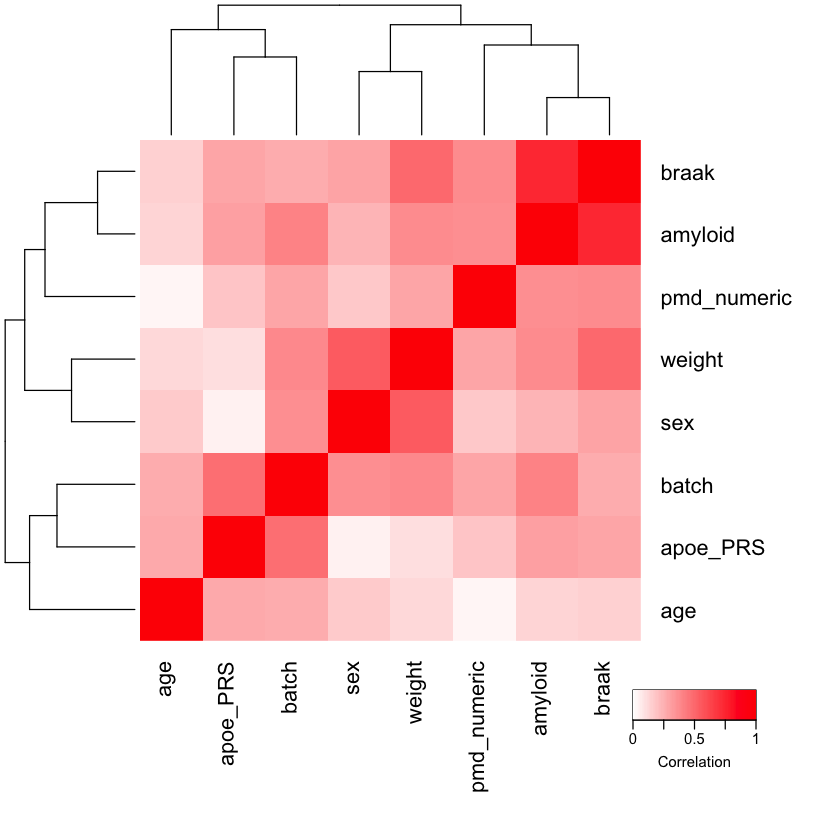

In [103]:
plotCorrMatrix(C, margins = c(10, 10), key.xlab = "Correlation")

In [104]:
pdf("100_plus_plots/proteomics/correlation_between_variables-20230522.pdf", width=6, height=6)
plotCorrMatrix(C, margins = c(9, 9), key.xlab = "Correlation")
dev.off()

pdf 
  2

In [64]:
p <- plot_grid(p_1, p_2, ncol = 2, nrow = 1, greedy = FALSE, 
               labels = c("A", "B"), label_size = 20)
save_plot("100_plus_plots/proteomics/QC_variance_from.png", p, base_height = 6, base_width = 12)